#  Results and Analysis

In [1]:
from sklearn.dummy import DummyClassifier
import pandas as pd
from scipy import sparse
import pickle
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Training errors

In [16]:
file = '../../PycharmProjects/Case_Study_NLP/train_errors/loss_hist_train_h128_product.csv'
train_errors = pd.read_csv(file).drop(['Unnamed: 0'], axis=1)
train_errors.head()

,Train,Validate
0,0.551830,0.571996
1,0.414130,0.472075
2,0.349027,0.446983
3,0.297446,0.443454
4,0.251611,0.448819


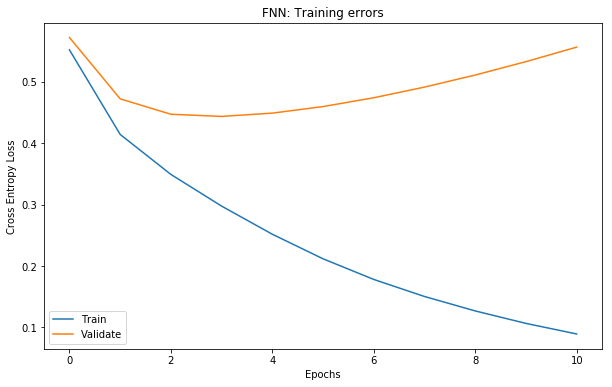

In [17]:
ax = train_errors.plot(legend=True, title='FNN: Training errors', figsize=(10,6))
ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss');

 Model 3 was selected for prediction. <br/> See training output below for misclassification rate on validation data

**Epoch 0/10**
<br/>Misclassification Rate: 16.532%
<br/>**Epoch 1/10**
<br/>Misclassification Rate: 14.143%
<br/>**Epoch 2/10**
<br/>Misclassification Rate: 13.472%
<br/>**Epoch 3/10**
<br/>Misclassification Rate: 13.466%
<br/>**Epoch 4/10**
<br/>Misclassification Rate: 13.584%
<br/>**Epoch 5/10**
<br/>Misclassification Rate: 13.825%
<br/>**Epoch 6/10**
<br/>Misclassification Rate: 14.166%
<br/>**Epoch 7/10**
<br/>Misclassification Rate: 14.507%
<br/>**Epoch 8/10**
<br/>Misclassification Rate: 14.759%
<br/>**Epoch 9/10**
<br/>Misclassification Rate: 15.268%
<br/>**Epoch 10/10**
<br/>Misclassification Rate: 15.626%

## Test predictions

Besides standard performance metrics, how can we judge if the model is learning or merely having luck with random guessing?

### Establish baseline

In [18]:
# Get training data, which the model was also trained on
X_train = sparse.load_npz('X_train_product.npz')
dataset_file = 'dataset_product.pickle'
with open(dataset_file, 'rb') as handle:
    dataset = pickle.load(handle)
y_train = dataset['y_train']

In [19]:
# Get untransformed test data
X_test = dataset['X_test']
y_test = dataset['y_test']


# Transform data
def clean_raw_text(text_as_series, tf_file, stopwords):
    tf = pickle.load(open(tf_file, 'rb'))
    series = text_as_series.reset_index(drop=True)

    def clean_num_punct(text):
        text = re.sub(r'([^a-zA-Z ]+?)', ' ', text)
        text = text.replace('X', '')
        text = text.replace('\n', ' ')
        return text.lower()

    series = series.apply(clean_num_punct)
    series = series.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords and len(word) > 1]))
    matrix = tf.transform(series)
    return matrix

X_test_matrix = clean_raw_text(text_as_series=X_test,
                                tf_file='tfidf_vec_product.pkl',
                                stopwords=stopwords.words('english'))

In [20]:
#print(X_test_matrix.shape, y_test.shape)
y_train = np.delete(y_train, 72576) # See *Note* in preprocessing nb
#print(X_train.shape, y_train.shape)

In [21]:
# Train dummy classifier to make predictions based on the class frequency
ways = ['stratified','most_frequent','prior','uniform']
for way in ways:
    new_dummy_classifier = DummyClassifier(strategy=way)
    new_dummy_classifier.fit(X_train,y_train)
    # Make predictions on transformed test data
    pred = new_dummy_classifier.predict(X_test_matrix)
    print(way + ' accuracy: ' + str(round(accuracy_score(y_test, pred), 3)))

stratified accuracy: 0.166
most_frequent accuracy: 0.246
prior accuracy: 0.246
uniform accuracy: 0.084


-------

### Test predictions

In [25]:
#Update this, needs to run
results = pd.read_csv('../../PyCharmProjects/Case_Study_NLP/data/model_3_test_predictions.csv')

In [26]:
print('Accuracy: ' + str(accuracy_score(results['True'], results['Pred'])))

Accuracy: 0.8645833333333334


In [2]:
le = pickle.load(open('label_encoder_product.pickle', 'rb'))
#cm = confusion_matrix(results['True'], results['Pred'])
#df_cm = pd.DataFrame(cm) # Without class names
##df_cm = pd.DataFrame(cm, index = [i for i in le.classes_],
##                     columns = [i for i in le.classes_])
#plt.figure(figsize = (10,8))
#plt.title('Test predictions')
#sns.heatmap(df_cm, annot=True, fmt="d");

In [1]:
#le.classes_

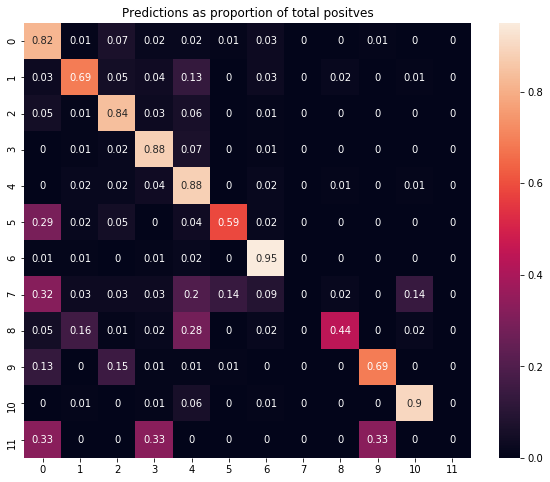

In [28]:
new_df = df_cm.copy()
for i in range(df_cm.shape[0]):
    for j in range(df_cm.shape[1]):
        new_df.iloc[i,j] = round(df_cm.iloc[i,j]/df_cm.iloc[i,:].sum(),2)
plt.figure(figsize = (10,8))
plt.title('Predictions as proportion of total positves')
sns.heatmap(new_df, annot=True);

In [ ]:
#print(classification_report(results['True'], results['Pred']))

**Add ROC Curves for classes**

## Conclusions/Summary